Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries


In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

Mounted at /content/gdrive


In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Create a dataset
Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## train dataset
## seed=123 used while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## resized images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## validation dataset
## seed=123 used while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## resized images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Listed out all the classes of skin cancer and stored them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualize the data
Created a code to visualize one instance of all the nine classes present in the dataset

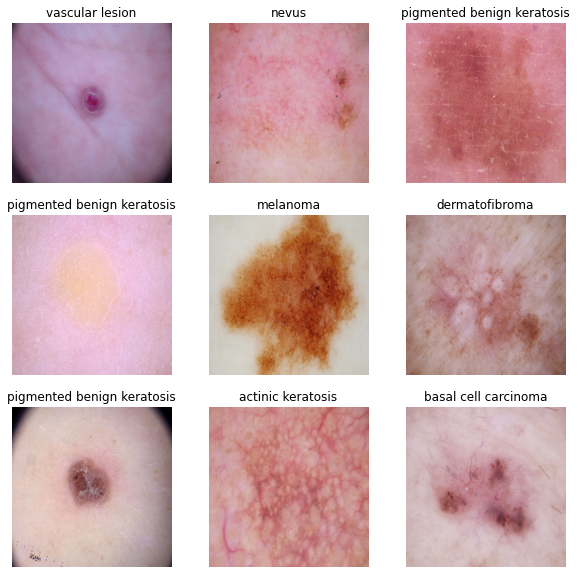

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
from keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Activation, Flatten, Dropout

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
activ = 'relu'

from keras.layers import Dense, Dropout, Activation,Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))                   
])
model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu',input_shape=(180,180,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3),padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
from tensorflow.keras.optimizers import Adam

### Appropirate optimiser and loss function chosen
model.compile(optimizer="Adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])


In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 43, 43, 128)       7

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
  )


Epoch 1/20
56/56 [==============================] - 152s 2s/step - loss: 0.0000e+00 - accuracy: 0.1696 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 138s 2s/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 127s 2s/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 138s 2s/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 131s 2s/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 129s 2s/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 129s 2s/step - loss: 0.0000e+00 - accuracy: 0.1724 - v

Visualizing training results

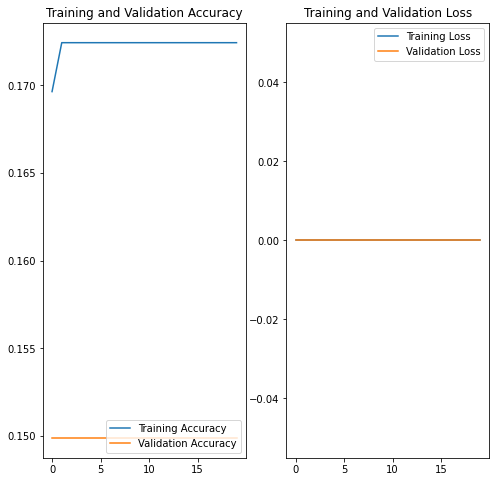

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Overfitting is seen in the above graph. 

When accuracy of train dataset is increases the validation dataset accuracy decreases.
If loss of train dataset is decreases the validation dataset accuracy is increasing drastically.

In [18]:
# Data augumentation strategy 
data_augument = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,0.3), width_factor=(0.2,0.3),fill_mode='reflect')
])

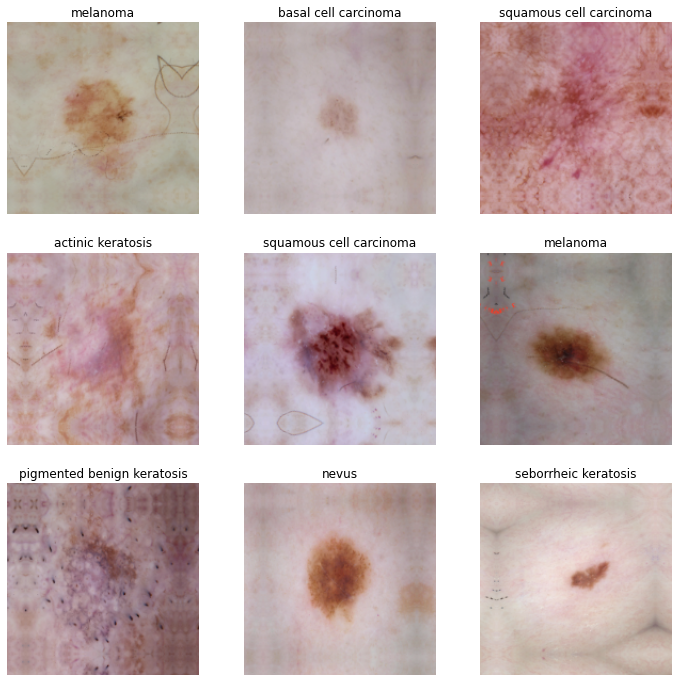

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12,12))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(data_augument(images)[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Todo:
Create the model, compile and train the model¶

In [20]:
## Used Dropout layer in model building due to evidence of overfitting


from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPool2D
num_classes = 9
model = Sequential([data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same',activation='relu',input_shape=(180,180,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same',activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))


### Compiling the model

In [6]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

NameError: ignored

Was not able to troubleshoot why model was not being recognised.



### Training the model

In [7]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
    

NameError: ignored

In [8]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
    

NameError: ignored